# WoS dataset characterization

In [15]:
import jsonlines
import numpy as np
from collections import Counter, OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the dataset

In [4]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_15Dec2023.jsonl') as reader:
    full_main = []
    for obj in reader:
        full_main.append(obj)

## Initial characterization

### Documents without abstracts
#### Main references

In [9]:
no_abstr = []
no_abstr_years = []
for doc in full_main:
    try:
        doc['abstract']
    except KeyError:
        no_abstr.append(doc['UID'])
        try:
            no_abstr_years.append(doc['year'])
        except KeyError:
            no_abstr_years.append(np.nan)
print(f'There are {len(full_main)} documents in the main search results, and {len(no_abstr)} of these are missing abstracts')

There are 6903 documents in the main search results, and 375 of these are missing abstracts


Is there a pattern to the documents missing abstracts in terms of what year they were published?

Text(0.5, 1.0, 'Publication years of papers without abstracts in main search results')

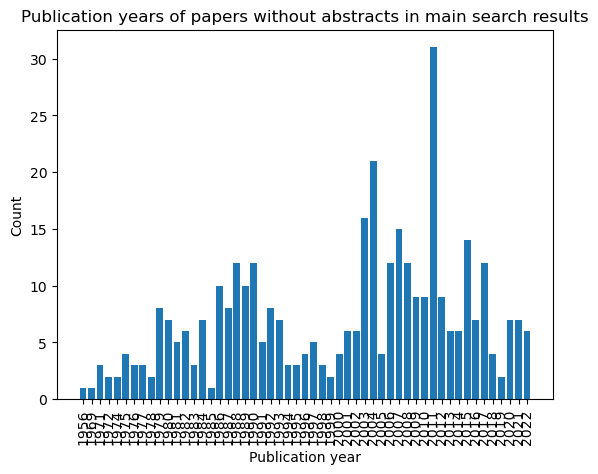

In [19]:
counted_years = OrderedDict(sorted(Counter(no_abstr_years).items()))
plt.bar(counted_years.keys(), counted_years.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Count')
plt.title('Publication years of papers without abstracts in main search results')

There is no clear pattern of publication year.

### Reference characterization
#### Number of references per paper

In [22]:
num_refs = [len(doc['references']) for doc in full_main]
counted_refs = OrderedDict(sorted(Counter(num_refs).items()))
print(f'The papers in the search results have a mean of {sum(num_refs)/len(num_refs):.2f} references.')

The papers in the search results have a mean of 54.31 references.


Text(0.5, 1.0, 'Number of references per paper in dataset')

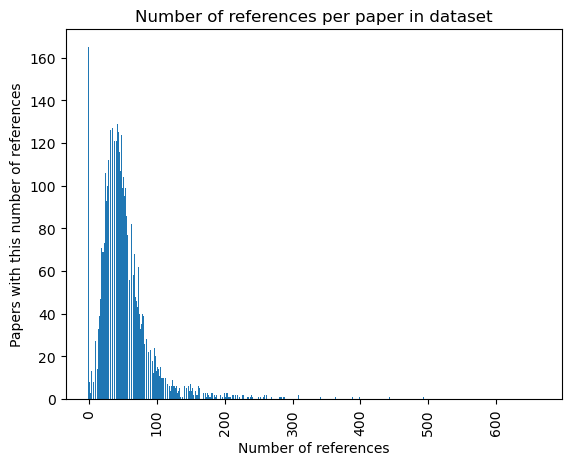

In [23]:
plt.bar(counted_refs.keys(), counted_refs.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Number of references')
plt.ylabel('Papers with this number of references')
plt.title('Number of references per paper in dataset')

There are a surprising number of papers with no references -- what's up there?

In [25]:
no_refs = [doc for doc in full_main if len(doc['references']) == 0]
print(f'There are {len(no_refs)} papers with no references in the dataset.')

There are 165 papers with no references in the dataset.


Do these overlap with the papers that have no abstract?

In [26]:
no_refs_and_no_abstract = [doc for doc in no_refs if doc['UID'] in no_abstr]
print(f'{len(no_refs_and_no_abstract)} of the papers with no references also have no abstract.')

132 of the papers with no references also have no abstract.


That is a high proportion, which makes sense and will be dropped from the dataset. What about the remaining 32 papers with no references? Let's pull a sample of their UIDs and manually check them; it's possible they actually have no references.

In [30]:
no_refs_but_abstract = [doc['UID'] for doc in no_refs if doc['UID'] not in no_abstr]
no_refs_but_abstract[:5]

['WOS:A1992JF38800001',
 'WOS:A1995RQ10400016',
 'WOS:A1991GG65200007',
 'WOS:A1992KD98900008',
 'WOS:A1992JQ67100004']

`WOS:A1992JF38800001` has references but they only exist in the scanned PDF. `WOS:A1995RQ10400016` has no version linlked on WoS. `WOS:A1991GG65200007` has a PDF with references, same with `WOS:A1992KD98900008`. These four are all from the early 90's; what does the year distribution look like for these papers?

Text(0.5, 1.0, 'Publication years of papers without references but that have abstracts')

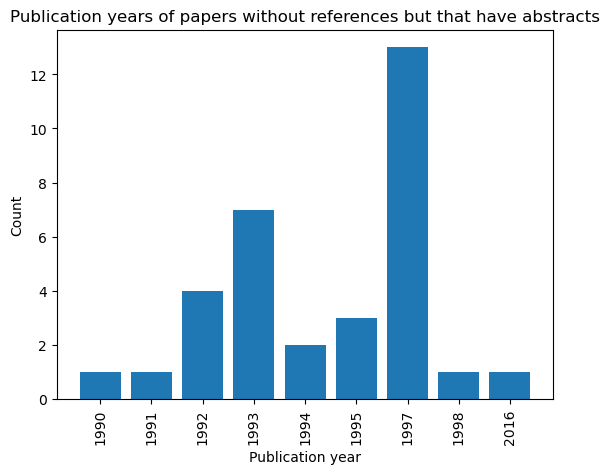

In [32]:
years_for_no_refs = [doc['year'] for doc in no_refs if doc['UID'] not in no_abstr]
counted_no_ref_years = OrderedDict(sorted(Counter(years_for_no_refs).items()))
plt.bar(counted_no_ref_years.keys(), counted_no_ref_years.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Count')
plt.title('Publication years of papers without references but that have abstracts')

They're all from the 90s with the exception of the one paper from 2016. Not sure what's going on there; may want to reach out to figure out if there's something funky going on.

####  Proportion of references not in Core Colection for main search results

In [52]:
no_core_props = []
no_uid_entries = []
total_refs = 0
for doc in full_main:
    UID = doc['UID']
    total_paper_refs = len(doc['references'])
    not_in_core = 0
    for ref in doc['references']:
        try:
            if ref['UID'].split('.')[0] == UID:
                try:
                    assert len(ref['UID'].split('.')) == 2
                    not_in_core += 1
                except AssertionError:
                    print(doc['UID'], ref['UID'])
        except KeyError:
            no_uid_entries.append(ref)
    try:
        no_core_props.append(not_in_core/total_paper_refs)
    except ZeroDivisionError:
        no_core_props.append(0)
    total_refs += total_paper_refs
print(f'There are {total_refs} references in the dataset as a whole.')

WOS:000625084200001 WOS:000625084200001
WOS:000623923100001 WOS:000623923100001
WOS:000615278100031 WOS:000615278100031
WOS:000708492600002 WOS:000708492600002
There are 374909 references in the dataset as a whole.


Four references have no UID. However, that is actually quite spectatular given that there are 374,909 total references.

Text(0, 0.5, 'Count')

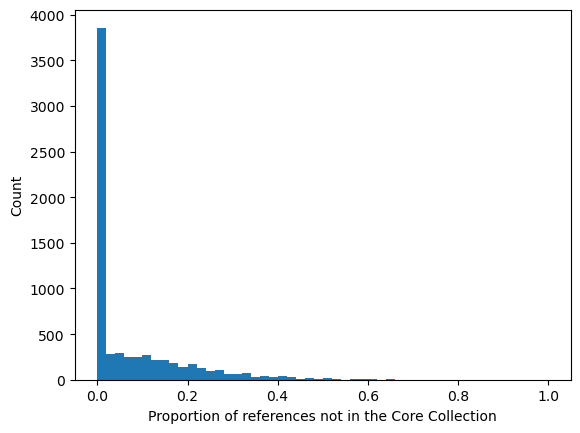

In [60]:
_ = plt.hist(no_core_props, bins=50)
plt.xlabel('Proportion of references not in the Core Collection')
plt.ylabel('Count')

In [62]:
print(f'{Counter(no_core_props)[0]} of {len(no_core_props)} papers have all references included in the Core Collection.')

3636 of 6903 papers have all references included in the Core Collection.


This is great! More than 1/3 of papers have all of their references in the Core Collection, and of those that don't, the overwhelming majority of the references (more than 75%) tend to be in the Core Collection.

#### Number of references without a year
This looks for references that didn't have a year recorded where they were referenced; however, it may be possible to ameliorate some of this when we go back and look for the paper abstracts.

In [63]:
refs_no_year = 0
for doc in full_main:
    for ref in doc['references']:
        try:
            ref['year']
        except KeyError:
            refs_no_year += 1

In [64]:
print(f'{refs_no_year} of {total_refs} total references are missing a year.')

527 of 374909 total references are missing a year.


Also really not bad!